# DATA CHALLENGE - THE ART OF THE POSSIBLE

## Prediction of total treatment time of patients

### Submitted by Ashish Ahuja

This notebook presents a predictive model for total treatment time of a patient in emergency department based on input features like age, complaint, diagnosis etc.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost
import csv as csv
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.model_selection import cross_val_score,KFold
#from sklearn.cross_validation import  train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
#from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.model_selection import GridSearchCV
from scipy.stats import skew
from collections import OrderedDict

### Data Cleaning

This section follows data cleaning approach explained in Exploratory Data Analysis notebook **EDA_basics.ipynb**

In [222]:
filename = 'Generic ED 2009.xlsx'
dataset = pd.read_excel(filename)
dataset.head()

,MRN,Presentation Visit Number,Triage Priority,Age (yrs),Arrival Date,Dr Seen Date,Depart Actual Date,Depart Status Code,Departure Status Desc.,Depart. Dest. Code,Depart. Dest. Desc.,TimeDiff Arrival-Actual Depart (mins),TimeDiff TreatDrNr-Act. Depart (mins),Presenting Complaint Code,Presenting Complaint Desc.,Diag Code,Diagnosis Desc.
0,67269,63190,3,15,2009-01-01 00:17:00,2009-01-01 02:11:00,2009-01-01 12:30:00,H,ED SERVICE EVENT COMPLETED - DISCHARGED,DISCH,* DISCHARGED,733,619.0,4000.0,DRUG / ALCOHOL / POISONING,F43.9,EMOTIONAL CRISIS
1,444991,63193,4,15,2009-01-01 00:35:00,2009-01-01 03:01:00,2009-01-01 07:35:00,W,DID NOT WAIT,DNW,* DID NOT WAIT,420,274.0,9000.0,INJURY,Z53.2,DID NOT WAIT
2,444992,63194,4,8,2009-01-01 00:55:00,2009-01-01 01:08:00,2009-01-01 01:08:00,H,ED SERVICE EVENT COMPLETED - DISCHARGED,DISCH,* DISCHARGED,13,0.0,7000.0,EYE,H10.9,CONJUNCTIVITIS
3,444999,63213,3,12,2009-01-01 03:22:00,2009-01-01 04:34:00,2009-01-01 05:00:00,H,ED SERVICE EVENT COMPLETED - DISCHARGED,DISCH,* DISCHARGED,98,26.0,25000.0,PAIN,H60.9,OTITIS EXTERNA
4,429921,63217,4,15,2009-01-01 03:55:00,2009-01-01 06:30:00,2009-01-01 08:29:00,H,ED SERVICE EVENT COMPLETED - DISCHARGED,DISCH,* DISCHARGED,274,119.0,9000.0,INJURY,S83.6,KNEE SPRAIN / STRAIN


In [223]:
diag_desc = dataset[dataset['Presenting Complaint Code'].isnull()].loc[:,'Diagnosis Desc.'].unique().tolist()
for diag in diag_desc:
    df_red = dataset[dataset['Diagnosis Desc.']==diag].groupby(['Presenting Complaint Desc.','Presenting Complaint Code'])['MRN'].count().reset_index()
    max_count = df_red.MRN.max()
    val = df_red[df_red.MRN==max_count].iloc[0,0]
    val1 = df_red[df_red.MRN==max_count].iloc[0,1]
    dataset.loc[np.array(dataset['Presenting Complaint Code'].isnull()) & np.array(dataset['Diagnosis Desc.']==diag),'Presenting Complaint Desc.']= val
    dataset.loc[np.array(dataset['Presenting Complaint Code'].isnull()) & np.array(dataset['Diagnosis Desc.']==diag),'Presenting Complaint Code']= val1

In [224]:
dataset.loc[dataset['TimeDiff TreatDrNr-Act. Depart (mins)'].isnull(),'TimeDiff TreatDrNr-Act. Depart (mins)'] = dataset.loc[dataset['TimeDiff TreatDrNr-Act. Depart (mins)'].isnull(),'TimeDiff Arrival-Actual Depart (mins)']/2

In [137]:
dataset['Diagnosis Desc.'] = dataset['Diagnosis Desc.'].str.replace("/","_")
dataset['Diagnosis Desc.'] = dataset['Diagnosis Desc.'].str.replace(" ","_")

In [138]:
dataset['Presenting Complaint Desc.'] = dataset['Presenting Complaint Desc.'].str.replace("/","_")
dataset['Presenting Complaint Desc.'] = dataset['Presenting Complaint Desc.'].str.replace(" ","_")

### Feature Selection and Engineering for Predictive Model

As seen in the exploratory data analysis, this dataset has many categorical and numerical features and some of them will be relevant for the predictive model to be developed for total time prediction. 

The task is to predict total time a patient will spend in the emergency department based on the information available at the time of entry, which is:

- MRN number of the patient
- Presentation Visit Number
- Age of the patient
- Complaint Description and its code.
- Diagnosis description and its code
- Time difference Arrival time to Doctor treatment

MRN number has been included in the model because if was seen in the EDA that there are patients who came more than once and it is assumed that this information will be helpful for the model.

Presentation visit number has also been included in the model but it is not expected to impact the performance much. The assumption is that it is assigned independently and is not related to any patient.

Time difference between arrival date and doctor seen date has been added to the dataset as a new feature. It needs to be highlighted that the feature 'TimeDiff TreatDrNr-Act. Depart (mins)', which represents time difference between depart date and doctor seen date is not considered in the model as this can cause data leakage. 

Following information has also been considered in the predictive model as this information is expected to be available after diagnosis.

- Depart Status Code
- Departure Status Description
- Depart. Dest. Code
- Depart. Dest. Desc.
- 'TimeDiff TreatDrNr-Act. Depart (mins)'




In [225]:
# New Feature 
dataset['TimeDiff_Dr_Arrvial'] = dataset.loc[:,'TimeDiff Arrival-Actual Depart (mins)']-dataset.loc[:,'TimeDiff TreatDrNr-Act. Depart (mins)']

In [249]:
categorical_features = ['MRN','Presentation Visit Number','Presenting Complaint Code','Diag Code','Depart. Dest. Code','Depart. Dest. Desc.','Depart Status Code','Departure Status Desc.']
#categorical_features = ['MRN','Presentation Visit Number','Presenting Complaint Code','Presenting Complaint Desc','Diag Code','Diagnosis Desc']
#categorical_features = ['MRN','Presentation Visit Number','Presenting Complaint Code','Diag Code']
#feature_columns = ['Triage Priority', ' Age  (yrs)','TimeDiff_Dr_Arrvial','MRN','Presenting Complaint Code','Presenting Complaint Desc.','Diag Code','Diagnosis Desc.','Depart. Dest. Code','Depart Status Code']
#feature_columns = ['Triage Priority', ' Age  (yrs)','TimeDiff_Dr_Arrvial','MRN','Presentation Visit Number','Presenting Complaint Code','Presenting Complaint Desc','Diag Code','Diagnosis Desc']
#feature_columns = ['Triage Priority', ' Age  (yrs)','TimeDiff_Dr_Arrvial','MRN','Presentation Visit Number','Presenting Complaint Code','Diag Code']
feature_columns = ['Triage Priority', ' Age  (yrs)','TimeDiff_Dr_Arrvial','MRN','Presentation Visit Number','Presenting Complaint Code','Diag Code','Depart. Dest. Code','Depart. Dest. Desc.','Depart Status Code','Departure Status Desc.']
target_column = ['TimeDiff Arrival-Actual Depart (mins)']

In [167]:
dataset.columns = ['MRN', 'Presentation Visit Number', 'Triage Priority', ' Age  (yrs)',
       'Arrival Date', 'Dr Seen Date', 'Depart Actual Date',
       'Depart Status Code', 'Departure Status Desc.', 'Depart. Dest. Code',
       'Depart. Dest. Desc.', 'TimeDiff Arrival-Actual Depart (mins)',
       'TimeDiff TreatDrNr-Act. Depart (mins)', 'Presenting Complaint Code',
       'Presenting Complaint Desc', 'Diag Code', 'Diagnosis Desc',
       'TimeDiff_Dr_Arrvial']

In [188]:
dataset_copy = dataset.copy(deep=True)

In [197]:
dataset.drop(dataset[dataset['Diagnosis Desc']=='DID_NOT_WAIT'].index, inplace=True)

In [199]:
dataset.shape

(26979, 18)

In [250]:
X = dataset.loc[:,feature_columns]
y = dataset.loc[:,target_column]
y.columns = ['Target']

In [251]:
dataset.columns

Index(['MRN', 'Presentation Visit Number', 'Triage Priority', ' Age  (yrs)',
       'Arrival Date', 'Dr Seen Date', 'Depart Actual Date',
       'Depart Status Code', 'Departure Status Desc.', 'Depart. Dest. Code',
       'Depart. Dest. Desc.', 'TimeDiff Arrival-Actual Depart (mins)',
       'TimeDiff TreatDrNr-Act. Depart (mins)', 'Presenting Complaint Code',
       'Presenting Complaint Desc.', 'Diag Code', 'Diagnosis Desc.',
       'TimeDiff_Dr_Arrvial'],
      dtype='object')

In [252]:
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

### Target Encoding of Categorical Variables

In [253]:
import category_encoders as ce

In [254]:
#Create target encoding object
encoder=ce.TargetEncoder(cols=categorical_features) 

In [255]:
#Fit and Transform Train Data
transformed_feature = encoder.fit_transform(X_train[categorical_features],y_train)

C:\Users\Aashna\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [256]:
X_train.head()

,Triage Priority,Age (yrs),TimeDiff_Dr_Arrvial,MRN,Presentation Visit Number,Presenting Complaint Code,Diag Code,Depart. Dest. Code,Depart. Dest. Desc.,Depart Status Code,Departure Status Desc.
20404,5,8,24.0,361308,6122,22000.0,Z47.8,DISCH,* DISCHARGED,H,ED SERVICE EVENT COMPLETED - DISCHARGED
9407,3,12,117.0,231374,22696,32000.0,J06.9,DISCH,* DISCHARGED,H,ED SERVICE EVENT COMPLETED - DISCHARGED
12698,4,0,127.0,453197,36400,24000.0,Z53.2,DNW,DID NOT WAIT,W,DID NOT WAIT
18275,3,4,72.0,330872,60626,32000.0,Z53.2,DNW,DID NOT WAIT,W,DID NOT WAIT
1514,3,0,20.0,437784,70322,24000.0,N39.0,2F,2F - PAEDIATRICS,A,ADMITTED (EXCL.ED BED)


In [257]:
#transformed_feature.columns = ['MRN_trans','complaint_trans','complaint_desc_trans','diagnosis_trans','Depart_Dest_trans','Depart_Status_Code_trans']
transformed_feature.head()

,MRN,Presentation Visit Number,Presenting Complaint Code,Diag Code,Depart. Dest. Code,Depart. Dest. Desc.,Depart Status Code,Departure Status Desc.
20404,153.158266,203.588075,116.662121,89.861963,178.831484,178.831484,179.018519,179.018519
9407,308.178552,203.588075,226.088068,187.030837,178.831484,178.831484,179.018519,179.018519
12698,161.966237,203.588075,207.741723,150.055598,156.388718,135.867954,153.668672,153.668672
18275,169.163934,203.588075,226.088068,150.055598,156.388718,135.867954,153.668672,153.668672
1514,203.588075,203.588075,207.741723,292.064777,408.181892,408.181892,409.033661,409.033661


In [258]:
X_train_copy = X_train.copy(deep=True)
X_train_copy.drop(categorical_features,axis=1,inplace=True)

In [259]:
X_train_trans = pd.concat([X_train_copy,transformed_feature],axis=1)

In [260]:
X_train_trans.columns

Index(['Triage Priority', ' Age  (yrs)', 'TimeDiff_Dr_Arrvial', 'MRN',
       'Presentation Visit Number', 'Presenting Complaint Code', 'Diag Code',
       'Depart. Dest. Code', 'Depart. Dest. Desc.', 'Depart Status Code',
       'Departure Status Desc.'],
      dtype='object')

In [261]:
#X_train_trans.drop(categorical_features,axis=1,inplace=True)
X_train_trans.head()

,Triage Priority,Age (yrs),TimeDiff_Dr_Arrvial,MRN,Presentation Visit Number,Presenting Complaint Code,Diag Code,Depart. Dest. Code,Depart. Dest. Desc.,Depart Status Code,Departure Status Desc.
20404,5,8,24.0,153.158266,203.588075,116.662121,89.861963,178.831484,178.831484,179.018519,179.018519
9407,3,12,117.0,308.178552,203.588075,226.088068,187.030837,178.831484,178.831484,179.018519,179.018519
12698,4,0,127.0,161.966237,203.588075,207.741723,150.055598,156.388718,135.867954,153.668672,153.668672
18275,3,4,72.0,169.163934,203.588075,226.088068,150.055598,156.388718,135.867954,153.668672,153.668672
1514,3,0,20.0,203.588075,203.588075,207.741723,292.064777,408.181892,408.181892,409.033661,409.033661


In [262]:
#Transform Test Data
trans_feat_test = encoder.transform(X_test[categorical_features])

In [263]:
#trans_feat_test.columns = ['MRN_trans','complaint_trans','diagnosis_trans','Depart_Dest_trans','Depart_Status_Code_trans']
trans_feat_test.head()

,MRN,Presentation Visit Number,Presenting Complaint Code,Diag Code,Depart. Dest. Code,Depart. Dest. Desc.,Depart Status Code,Departure Status Desc.
17411,372.347941,203.588075,207.741723,195.261350,178.831484,178.831484,179.018519,179.018519
4513,203.588075,203.588075,245.881818,144.205742,178.831484,178.831484,179.018519,179.018519
12854,216.416452,203.588075,212.350727,214.552273,178.831484,178.831484,179.018519,179.018519
20464,203.588075,203.588075,116.662121,89.861963,178.831484,178.831484,179.018519,179.018519
9289,126.734353,203.588075,207.741723,272.089308,178.831484,178.831484,179.018519,179.018519


In [264]:
X_test_copy = X_test.copy(deep=True)
X_test_copy.drop(categorical_features,axis=1,inplace=True)

In [265]:
X_test_trans = pd.concat([X_test_copy,trans_feat_test],axis=1)


In [266]:
#X_test_trans.drop(categorical_features,axis=1, inplace=True)
X_test_trans.head()

,Triage Priority,Age (yrs),TimeDiff_Dr_Arrvial,MRN,Presentation Visit Number,Presenting Complaint Code,Diag Code,Depart. Dest. Code,Depart. Dest. Desc.,Depart Status Code,Departure Status Desc.
17411,3,0,99.0,372.347941,203.588075,207.741723,195.261350,178.831484,178.831484,179.018519,179.018519
4513,3,9,76.0,203.588075,203.588075,245.881818,144.205742,178.831484,178.831484,179.018519,179.018519
12854,4,15,30.0,216.416452,203.588075,212.350727,214.552273,178.831484,178.831484,179.018519,179.018519
20464,5,14,27.0,203.588075,203.588075,116.662121,89.861963,178.831484,178.831484,179.018519,179.018519
9289,3,1,61.0,126.734353,203.588075,207.741723,272.089308,178.831484,178.831484,179.018519,179.018519


### Using XGBOOST Regressor

In [267]:
model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 

In [268]:
#model = xgboost.XGBRegressor()

In [269]:
model.fit(X_train_trans,y_train)

#OrderedDict(sorted(model.booster().get_fscore().items(), key=lambda t: t[1], reverse=True))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.07, max_delta_step=0, max_depth=3,
             min_child_weight=1.5, missing=nan, monotone_constraints='()',
             n_estimators=10000, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
             subsample=0.6, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [219]:
from xgboost import plot_importance

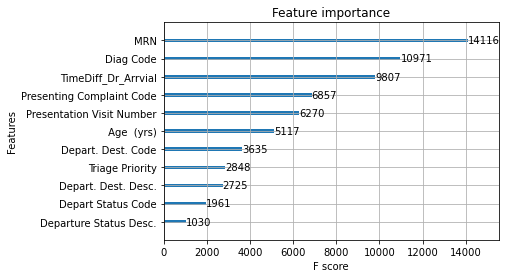

In [270]:
plot_importance(model)
plt.show()

In [41]:
def adjusted_rsquared(X,y,yhat):
    #yhat = model.predict(X)
    SS_Residual = sum((y-yhat)**2)       
    SS_Total = sum((y-np.mean(y))**2)     
    r_squared = 1 - (float(SS_Residual))/SS_Total
    adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)
    return adjusted_r_squared


In [42]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [43]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

def score_metrics(model,X,y,dataset='training', print_output = True):
    y_pred = model.predict(X)
    rsquared = r2_score(y,y_pred)
    adj_rsquared = adjusted_rsquared(X,y,y_pred)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = mean_squared_error(y, y_pred,squared = False)
    mape=mean_absolute_percentage_error(y, y_pred)
    
    if print_output:
        # Calculate the score (R^2 for Regression) for Training Data
        print('R-squared error on ' + dataset + ' data = ' + str(rsquared))

        # Calculate the score (R^2 for Regression) for Training Data
        print('Adjusted R-squared error on ' + dataset + ' data = ' + str(adj_rsquared))

        print('Mean Absolute Error on ' + dataset + ' data = ' + str(mae))
        print('Mean Squared Error on ' + dataset + ' data = '+ str(mse))
        print('Root Mean Squared Error on ' + dataset + ' data = '+ str(rmse))
        print('Mean Absolute Percentage Error ' + dataset+ ' data = ' + str(mape))

    return rsquared, adj_rsquared, mae, mse, rmse, mape    
    
    

In [271]:
# Score
print('-------------------------------------------')
print('XgBoost Regression - Training Data Performance.....')
print('-------------------------------------------')
rsquared, adj_rsquared, mae, mse, rmse, mape=score_metrics(model,X_train_trans,y_train.Target.values,'training')
print('-------------------------------------------')

print('-------------------------------------------')
print('XgBoost Regression - Testing Data Performance.....')
print('-------------------------------------------')
rsquared_test, adj_rsquared_test, mae_test, mse_test, rmse_test, mape_test= score_metrics(model,X_test_trans,y_test.Target.values,'test')
print('-------------------------------------------')

-------------------------------------------
XgBoost Regression - Training Data Performance.....
-------------------------------------------
R-squared error on training data = 0.7275471630232704
Adjusted R-squared error on training data = 0.7274230027280125
Mean Absolute Error on training data = 61.069898413819246
Mean Squared Error on training data = 8465.706989707314
Root Mean Squared Error on training data = 92.00927665027757
Mean Absolute Percentage Error training data = 50.31162555910142
-------------------------------------------
-------------------------------------------
XgBoost Regression - Testing Data Performance.....
-------------------------------------------
R-squared error on test data = 0.29066759401262143
Adjusted R-squared error on test data = 0.2893727622061315
Mean Absolute Error on test data = 90.03026838115447
Mean Squared Error on test data = 22471.490039219443
Root Mean Squared Error on test data = 149.90493667394495
Mean Absolute Percentage Error test data = 66.

In [36]:
#for tuning parameters
parameters_for_testing = {
    'colsample_bytree':[0.4,0.6,0.8],
    'gamma':[0,0.03,0.1,0.3],
    'min_child_weight':[1.5,6,10],
    'learning_rate':[0.1,0.07],
    'max_depth':[3,5],
    'n_estimators':[10000],
    'reg_alpha':[1e-5, 1e-2,  0.75],
    'reg_lambda':[1e-5, 1e-2, 0.45],
    'subsample':[0.6,0.95]  
}

                    
xgb_model = xgboost.XGBRegressor(learning_rate =0.1, n_estimators=1000, max_depth=5,
     min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=27)

gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, n_jobs=6,iid=False, verbose=10,scoring='neg_mean_squared_error')
gsearch1.fit(X_train_trans,y_train)
print (gsearch1.grid_scores_)
print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)

Fitting 5 folds for each of 2592 candidates, totalling 12960 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  8.7min
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed: 12.4min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed: 32.3min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed: 35.9min
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed: 39.4min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed: 41.4min
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed: 47.7min
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed: 52.3min
[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed: 57.4min
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed: 64.5min
[Parallel(n_jobs=6)]: Done 133 tasks      | elapsed: 70.9min
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed: 75.1min
[Parallel(n_jobs=6)]: Done 169 tasks      | elapsed: 83.9min
[Parallel(

KeyboardInterrupt: 

### Binary Encoding of Categorical Features

In [120]:
#Create an object for Base N Encoding
encoder_bin= ce.BaseNEncoder(cols=categorical_features,base=2)
#Fit and Transform Train Data
trans_feat_binary = encoder_bin.fit_transform(X[categorical_features],y)

C:\Users\Aashna\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [121]:
trans_feat_binary.head()

,MRN_0,MRN_1,MRN_2,MRN_3,MRN_4,MRN_5,MRN_6,MRN_7,MRN_8,MRN_9,...,Diagnosis Desc._1,Diagnosis Desc._2,Diagnosis Desc._3,Diagnosis Desc._4,Diagnosis Desc._5,Diagnosis Desc._6,Diagnosis Desc._7,Diagnosis Desc._8,Diagnosis Desc._9,Diagnosis Desc._10
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [122]:
X_data = pd.concat([X, trans_feat_binary], axis = 1)
X_data.drop(categorical_features, axis = 1, inplace = True)
X_data.shape

(30188, 75)

In [123]:
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=0.2,random_state=42)

In [124]:
model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.07, max_delta_step=0, max_depth=3,
             min_child_weight=1.5, missing=nan, monotone_constraints='()',
             n_estimators=10000, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
             subsample=0.6, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [125]:
y_train.columns =['Target']
y_test.columns =['Target']

# Score
print('-------------------------------------------')
print('XgBoost Regression - Training Data Performance.....')
print('-------------------------------------------')
rsquared, adj_rsquared, mae, mse, rmse, mape=score_metrics(model,X_train,y_train.Target.values,'training')
print('-------------------------------------------')

print('-------------------------------------------')
print('XgBoost Regression - Testing Data Performance.....')
print('-------------------------------------------')
rsquared_test, adj_rsquared_test, mae_test, mse_test, rmse_test, mape_test= score_metrics(model,X_test,y_test.Target.values,'test')
print('-------------------------------------------')

-------------------------------------------
XgBoost Regression - Training Data Performance.....
-------------------------------------------
R-squared error on training data = 0.5015446242467022
Adjusted R-squared error on training data = 0.499991739259499
Mean Absolute Error on training data = 79.77428936505848
Mean Squared Error on training data = 15488.101373421534
Root Mean Squared Error on training data = 124.4512007713125
Mean Absolute Percentage Error training data = 65.731947834736
-------------------------------------------
-------------------------------------------
XgBoost Regression - Testing Data Performance.....
-------------------------------------------
R-squared error on test data = 0.18702535383725705
Adjusted R-squared error on test data = 0.17679840005291725
Mean Absolute Error on test data = 105.15926011927912
Mean Squared Error on test data = 25754.85274489079
Root Mean Squared Error on test data = 160.48318524035716
Mean Absolute Percentage Error test data = 82.00